Authors: Ran Harari and Yair Nof  
E-mails: [srharari@campus.technion.ac.il](srharari@campus.technion.ac.il), 
         [yairn@campus.technion.ac.il]()

# Battle environment (PettingZoo)

<div>
<img src="images\magent_battle.gif" width="300"/>
</div>


### Introduction

A large-scale team battle. Agents are rewarded for their individual performance, and not for the performance of their neighbors, so coordination is difficult. Agents slowly regain HP over time, so it is best to kill an opposing agent quickly. Specifically, agents have 10 HP (health points), are damaged 2 HP by each attack, and recover 0.1 HP every turn.

Agents can either move or attack each turn. An attack against another agent on their own team will not be registered.

Map is 45X45 grid   <br>
Each team has 81 agents at start

### Action space
Key: move_N means N separate actions, one to move to each of the N nearest squares on the grid.

Action options: [do_nothing, move_12, attack_8] -> total `Discrete(21)` actions
<div>
<img src="images\action_space.png" width="500"/>
</div>

### Reward
Reward is given as:
* 5 reward for killing an opponent
* -0.005 reward every step (step_reward option)
* -0.1 reward for attacking (attack_penalty option)
* 0.2 reward for attacking an opponent (attack_opponent_reward option)
* -0.1 reward for dying (dead_penalty option)
* If multiple options apply, rewards are added.

### Observation space
The observation space is a 13x13 map with the below channels (in order):

* obstacle/off the map	1
* my_team_presence	1
* my_team_hp	1
* other_team_presence	1
* other_team_hp	1

<div>
   <img src="images\obs.png" width="500"/>
</div>

*Note that basic observation doesn't include agent's position. There is an option to get extra features in the obs (including agent's pos)

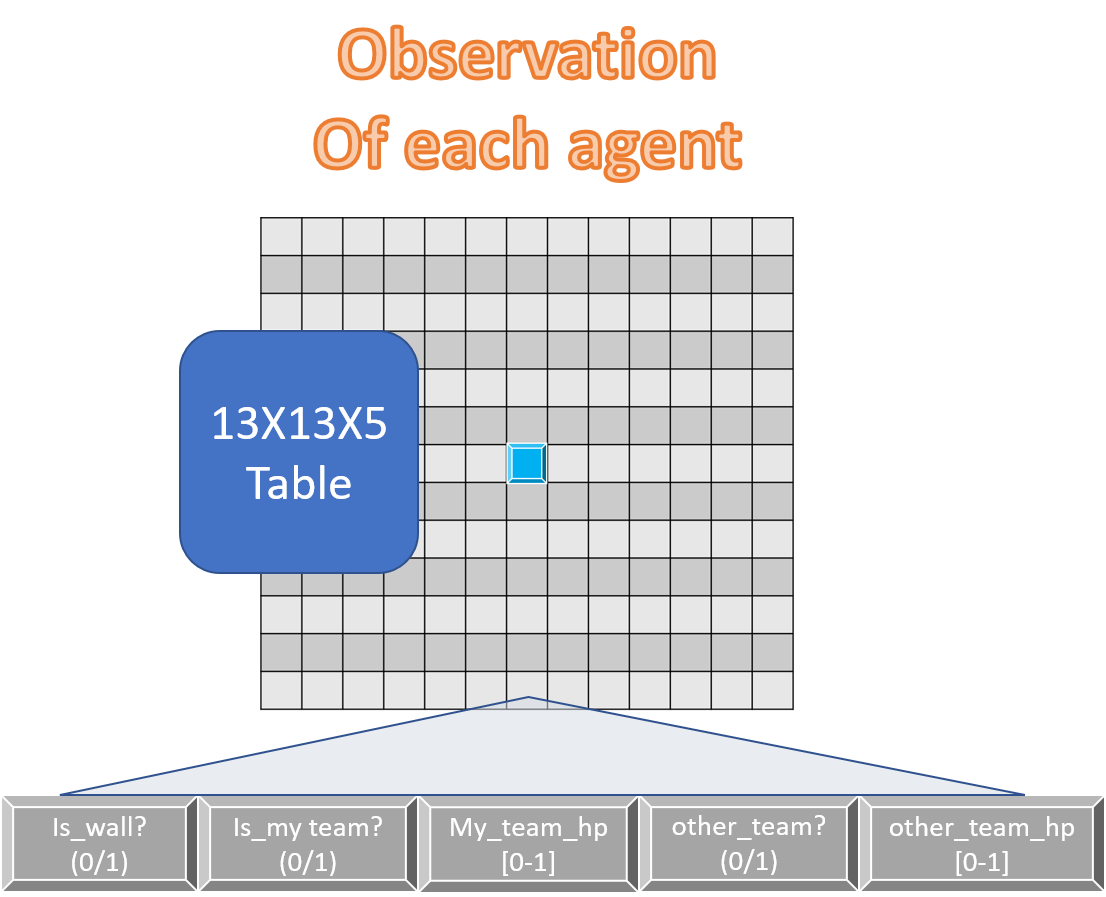

## Multi-Agent control approches
---
We will try to 'solve' battle Multi-Agent team control problem using several approches:
* Distrbuted control decision makers
  * Random control
  * simple rule-based control
  * using graph-based planning and alghoritms
  * combination of last 3 approches
  * DQN/PPO RL agents
* Local planners and Team centerlized Coordinator
  * Greedy-rule-based coordinator
  * Collision-avoid coordinator 
  
 <div>
<img src="images\coordinator.png" width="350"/>
</div>

* HTN - High level RL, low-level planner
  * High level tasks - group / attack / defend - using RL 
  * Low level actions - using a planner


## Setting the environment
### Architecture, wrappers and useful functions

<div>
<img src="images\team_architechture.png" width="550"/>
</div>

[TODO - complete]()


In [1]:
"""
Lets start with our imports
"""

from abc import ABC, abstractmethod
from copy import deepcopy
from warnings import filterwarnings

from gym.spaces import Discrete
from pettingzoo.magent import battlefield_v5, battle_v4
from stable_baselines3 import PPO
import time

from agents import Agent
from environments import EnvWrapperPZ
from utils.battle_field_ulits import all_est_agents_pos_seq, action_str_to_num
from utils.factory import CreateSimulationController
from utils.functions import CreateDecentralizedAgents
from agents.agent import DecisionMaker
from control import Controller
from utils.performance import forbidden_plans

"""
we use MAC (updated), and ai_dm from sarah's git tools
"""

# A Wrapper for the pettingzoo environment within MAC
class BattleFieldEnv(EnvWrapperPZ):
    def __init__(self, env):
        super().__init__(env)
        self.obs = self.env.reset()
        # print(self.obs)

    def step(self, joint_action):
        return self.env.step(joint_action)

    def observation_to_dict(self, obs):
        return obs

    def final_result(self):
        return self.env.team_sizes

    def reset(self):
        return self.env.reset()



# we will use a function that creates and reset our environment - we can set our rewards as necessary
def CreateEnvironment_Battle(minimap=False):
    # Create and reset PettingZoo environment
    BF_env = battle_v4.parallel_env(map_size=45, minimap_mode=minimap, step_reward=-0.005, dead_penalty=-7,
                                         attack_penalty=-0.01, attack_opponent_reward=0.8, max_cycles=400,
                                         extra_features=False)
    BF_env.reset()

    # Create a MAC from the PZ environment
    return BattleFieldEnv(BF_env)

# The abstract coordinator class with the abstract method approve_joint_plan
class coordinator(ABC):
    def __init__(self, env):
        self.OriginalEnv = env  # Original environment is saved to enable several resets to the simulated environment
        self.SimEnv = deepcopy(
            env)  # Create a copy of the environment to enable environment steps without changing the real environment

    @abstractmethod
    def approve_joint_plan(self,joint_plan):  # coordinate_color is the color which makes decisions. The other color is simulated
        pass


"""
we define a new class - Team that gets a decision maker and coordinator - and control the team accordingly
"""
class Team:
    def __init__(self, team_name, agents , coordinator : coordinator =None, plan_lenght = 1):
        self.team_name = team_name
        self.agents = agents
        try:
            self.agents_names = agents.keys()
        except:
            self.agents_names = None
        self.coordinator = coordinator
        self.plan_lenght = plan_lenght

    def get_agents(self):
        return self.decision_makers

    def get_agents_names(self):
        return self.agents_names

    def get_coordinator(self):
        return self.coordinator

    def get_joint_action(self, observation):
        """Returns the joint action

                Args:
                    observation (dict): the current observatins

                Returns:
                    dict: the actions for the agents
                """
        team_observations = {agent_id: observation[agent_id]
                            for agent_id in self.agents_names if agent_id in observation.keys() and agent_id}
        joint_action = {}
        joint_plan = {}
        for agent_name in team_observations.keys():
            if self.coordinator is not None:  # If there's a coordinator, the decision maker returns a plan
                try:
                    plan = self.agents[agent_name].get_decision_maker().get_plan(team_observations[agent_name],
                                                                                 self.plan_length)
                except:
                    plan = self.agents[agent_name].get_decision_maker().get_action(team_observations[agent_name])
                if isinstance(plan, int):  # correct single action plan to a list
                    plan = [plan]
                joint_plan[agent_name] = plan
            else:
                action = self.agents[agent_name].get_decision_maker().get_action(team_observations[agent_name])
                joint_action[agent_name] = action

        # The coordinator's approve_joint_action returns the next joint action, after considering the joint plan
        if self.coordinator is not None:
            joint_action = self.coordinator.approve_joint_plan(joint_plan)
        return joint_action

"""
now we use MAC controller to build our Teams controller
"""
class TeamsController(Controller):
    """controller for running teams in the game
        each can have its own coordinator/agents
            """

    def __init__(self, env, teams):
        # initialize super class
        super().__init__(env)
        self.teams = teams


    def get_joint_action(self, observation):
        """Returns the joint action

        Args:
            observation (dict): the current observatins

        Returns:
            dict: the actions for the agents
        """

        joint_action = {}
        for team in self.teams:
            joint_action.update(team.get_joint_action(observation))
        return joint_action


"""
 function - Creates identical agents with the same decision maker for agents names and optional coordinator for central 'control'
"""
def CreateDecentralizedAgentsTeam(env, team_name, decision_maker,agent_names,coordinator=None):
    if isinstance(decision_maker,DecisionMaker):
        decentralized_agents = {
            agent_id: Agent(deepcopy(decision_maker))
            for agent_id in agent_names
        }
    else:
        decentralized_agents = {
            agent_id: Agent(decision_maker(env.action_spaces[agent_id]))
            for agent_id in agent_names
        }
    return Team(team_name,decentralized_agents,coordinator)

# Create and run rounds using teams -> ruturns results and average of all rounds
def CreateTeamsController(env, teams, render=True,max_iters=1000, rounds=1):
    teams_controller = TeamsController(env, teams)

    average_score_and_rewards = [["red_team_avarage",0,0],["blue_team_average",0,0]]
    results = []
    for i in range(rounds):
        # Running the decentralized agents
        teams_controller.run(render=render, max_iteration=max_iters)

        # save and return results of this round
        total_rewards = teams_controller.total_rewards
        red_total_rewards = sum(total_rewards[item] for item in total_rewards if "red" in item)
        blue_total_rewards = sum(total_rewards[item] for item in total_rewards if "blue" in item)
        last_lives = env.final_result()
        result = ["red_team",last_lives[0],red_total_rewards],["blue_team",last_lives[1],blue_total_rewards]
        results.append(result)
        for m in range(1,3):
            average_score_and_rewards[0][m]+=(result[0][m]-average_score_and_rewards[0][m])/(i+1)
            average_score_and_rewards[1][m]+=(result[1][m] - average_score_and_rewards[1][m]) / (i + 1)

    # print(f"{result}")
    return results + average_score_and_rewards

ModuleNotFoundError: No module named 'pettingzoo'

## 1. Distrebuted Agents-Decision Makers

* Random controller as a baseline 'stupid' DM
* Stand-Still only - Stay DM

[TODO - complete]()

In [4]:
"""
now after we set the right architecture and helping functions - we are ready to try our controller 'brains'
"""

"""
first we will make a simple random decition maker for a 'stupid' baseline
"""

# random DM:

class RandomDecisionMaker(DecisionMaker):
    def __init__(self, action_space):
        self.space = action_space

    def get_action(self, observation):
        if isinstance(self.space, dict):
            return {agent: self.space[agent].sample() for agent in self.space.keys()}
        else:
            return self.space.sample()

    # Random plan - the result of a random sequence of get_action calls
    def get_plan(self, observation, plan_length):
        plan = [self.get_action(None) for _ in range(0, plan_length)]  # Blind action choice
        return plan

"""
We will also make a simple DM that always stand still (agents use only stay action) 
"""

class Stay_DM(DecisionMaker):
    def __init__(self, action_space):
        self.action_space=action_space

    def get_action(self, observation):
        return 6 # 6 - stay in place

### Round 1 - stay DM VS random DM

In [4]:
# test our teams -
print("----------------------------------\n"
      "Round 1 : blue-random VS red-stay\n"
      "-----------------------------------")

# first - set the env and agents names
env = CreateEnvironment_Battle(minimap=False)
agents = env.get_env_agents()
red_agents  = [agent for agent in agents if "red" in agent]
blue_agents = [agent for agent in agents if "blue" in agent]

# set our teams:
team1 = CreateDecentralizedAgentsTeam(env,"blues",RandomDecisionMaker,blue_agents)
team2 = CreateDecentralizedAgentsTeam(env,"reds",Stay_DM,red_agents)
# run 2 rounds
results = CreateTeamsController(env,[team1,team2],render=True,max_iters=15,rounds=2)
for r in results: print(r)

NameError: name 'DecisionMaker' is not defined

* Rule-based planner - will be used as a baseline and for coordinators checking 
    * simple rule-based DM-planner (for more details - look inside simple_planner2.py file)
        * epsilon - chance of making random choise
        * if life is above 5HP -> search closer rival and attack
        * else -> make defensive move   
    * Smart planner - Rule-based + graph-based (a* and more) + Boids sweep rules 
        * epsilon - chance of making random choise
        * if life is above 5HP -> search closer rival and attack
            *search method we be a sweep alg. - agents move together in the same direction that changes each 50 moves
        * else -> make defensive -> make defensive move  
    this will be our 'smart' planner baseline - it will be hard to win against this team

[TODO - complete]()



* First - we import a simple rule-based DM-planner (for more details - look inside simple_planner2.py file)
  *  epsilon - chance of making random choise
  * if life is above 5HP -> search closer rival and attack
      *  else -> make defensive move   

#### Round 2 - <font color=blue> random  </font> VS <font color=red> Rule-based simple planner

[TODO - complete]()


In [ ]:
from DMs.simple_planner2 import Simple_DM2

# test our teams -
print("------------------------------------------\n"
      "Round 2 : blue-random VS red-rule based DM\n"
      "--------------------------------------------")
# set our teams:
team1 = CreateDecentralizedAgentsTeam(env,"blues",RandomDecisionMaker,blue_agents)
team2 = CreateDecentralizedAgentsTeam(env,"reds",Simple_DM2,red_agents)
# run 1 rounds
results = CreateTeamsController(env,[team1,team2],render=True,max_iters=300,rounds=1)
for r in results: print(r)

"""
now - we will try using graph-based (a* and more) and Boids rules to make even a
      better planner - 
      epsilon - chance of making random choise
      if life is above 5HP -> search closer rival and attack
        *search method we be a sweep alg. - agents move together in the same direction that changes each 50 moves
      else -> make defensive -> make defensive move  

    this will be our 'smart' planner baseline - it will be hard to win against this team
"""

# import a smart DM-planner (for more details - look inside simple_planner.py file)

from DMs.simple_planner import Simple_DM

### Round 3 - simple rule-based DM VS smart DM-planner 

In [ ]:
# test our teams -
print("--------------------------------------------\n"
      "Round 3 : red-simple DM VS blue-smart planner\n"
      "--------------------------------------------")
# set our teams:
team1 = CreateDecentralizedAgentsTeam(env,"blues",Simple_DM,blue_agents)
team2 = CreateDecentralizedAgentsTeam(env,"reds",Simple_DM2,red_agents)
# run 1 rounds
results = CreateTeamsController(env,[team1,team2],render=True,max_iters=300,rounds=1)
for r in results: print(r)

* A* / Graph-based alg.

[TODO - complete]()


* RL - PPO simple agent

[TODO - complete]()


"""
Now lets try a to train a single distributed RL agent (using PPO from stable-baseline3)
"""

"""
Before we can train an RL agent we must wrap an env that can isolate 1 single agent
this way we can train the agent as it take actions in its own single environment
"""

In [ ]:
# a single agent Battle ENV Wrapper
class BattleFieldSingleEnv():
    def __init__(self, env,blue_other_dm, red_DM, agent="blue_0"):
        self.env = env
        self.action_space = env.action_spaces[agent]
        self.observation_space = env.observation_spaces[agent]
        self.agent_name = agent
        self.agents = CreateDecentralizedAgents(env, blue_other_dm, red_DM)
        self.others_blue_DM = blue_other_dm
        self.others_red_DM = red_DM
        self.all_obs = self.env.reset()
        self.obs = self.all_obs[agent]
        self.metadata = None
        # print(self.obs)

    def step(self, action):
        joint_action = {}
        for agent_name in self.all_obs.keys():
            act = self.agents[agent_name].get_decision_maker().get_action(self.all_obs[agent_name])
            joint_action[agent_name] = act
        joint_action[self.agent_name] = action
        self.all_obs, reward, done, self.metadata = self.env.step(joint_action)
        try:
            self.obs = self.all_obs[self.agent_name]
        except:
            return (None, None, True, self.metadata)
        return (self.obs, reward[self.agent_name], done[self.agent_name], self.metadata)

    def observation_to_dict(self, obs):
        return obs

    def render(self):
        return self.env.render()

    def reset(self):
        self.all_obs = self.env.reset()
        self.obs = self.all_obs[self.agent_name]
        return self.obs

    def print_env_info(self):
        for i, agent in enumerate(self.env.agents, 1):
            print(f'- agent {i}: {agent}')
            print(f'\t- observation space: {self.env.observation_space(agent)}')
            print(f'\t- action space: {self.env.action_space(agent)}')
            print(f'\t- action space sample: {self.env.action_space(agent).sample()}')

* Now we can train the agent using stable-baseline PPO
    it takes a lot of time to get an effetive result (that still doesn't perform so good)
    we saved it for you (for training info - look at PPO_DM1.py)
"""

In [ ]:
from DMs.PPO_DM1 import PPODecisionMaker

#### Round 4 - <font color=blue> simple-RL-PPO </font> VS <font color=red> Rule-based planner 

[TODO - complete]()

In [ ]:
# test our teams -
print("-------------------------------------------------\n"
      "Round 4 : red-smart DM-planner VS blue-RL-PPO dec.\n"
      "-------------------------------------------------")
# set our teams:
team1 = CreateDecentralizedAgentsTeam(env,"blues",PPODecisionMaker,blue_agents)
team2 = CreateDecentralizedAgentsTeam(env,"reds",Simple_DM(env.action_spaces["red_1"], red_team=True),red_agents)
# run 1 rounds
results = CreateTeamsController(env,[team1,team2],render=True,max_iters=100,rounds=1)
for r in results: print(r)

## 2. Coordinators and Teams central control



[TODO - complete]()


In [ ]:
"""
Coordinator - getting started
    TODO - complete
"""


# for testing: A Coordinator that allow all plans - it returns for each agent the first action of its plan,
# as the next action for a controller
class IdentityCoordinator(coordinator):
    def __init__(self, env):
        super().__init__(env)

    def approve_joint_plan(self, joint_plan):
        return {agent: plan[0] for (agent, plan) in joint_plan.items()} # Take the first action of each joint plan, as is


# A coordinator which consider which plans to allow by simulating it in the environment.
# The greedy method in this case try and check in each iteration what is the best plan, given the previous plans
# This coordinator can be used for both sizes
class SimGreedyCoordinator(coordinator):
    def __init__(self, env, red_team=False):
        super().__init__(env)
        self.SimEnv = deepcopy(
            env)  # Create a copy of the environment to enable environment steps without changing the real environment
        if red_team :
            self.my_color ='red'
        else: self.my_color = 'blue'


    # This is the greedy vs. greedy coordination
    def approve_joint_plan(self, joint_plan):
        approved_plans = self.greedy_coordination(joint_plan, self.my_color)
        return {agent: plan[0] for (agent, plan) in approved_plans.items()}

    # # This is 'no coordination' vs. greedy coordination
    # def approve_joint_plan(self, joint_plan):
    #     approved_blue_plans = {agent: plan for (agent, plan) in joint_plan.items() if 'blue' in agent}
    #     approved_red_plans = self.greedy_coordination(joint_plan, 'red')
    #     return {**approved_red_plans, **approved_blue_plans}

    # # This is 'no coordination' vs. 'no coordination'
    # def approve_joint_plan(self, joint_plan):
    #     approved_blue_plans = {agent: plan for (agent, plan) in joint_plan.items() if 'blue' in agent}
    #     approved_red_plans = {agent: plan for (agent, plan) in joint_plan.items() if 'blue' in agent}
    #     return {**approved_red_plans, **approved_blue_plans}

    def greedy_coordination(self, joint_plan, coordinate_color):
        opponent_color = 'blue' if coordinate_color == 'red' else 'red'
        opponent_plans = {agent: plan for (agent, plan) in joint_plan.items() if opponent_color in agent}
        coordination_plans = {agent: plan for (agent, plan) in joint_plan.items() if coordinate_color in agent}
        checked_plans = opponent_plans  # Opponent plans are always the same

        for (agent, plan) in coordination_plans.items():  # Consider adding each plan
            if isinstance(plan,int):   # corrects single action to a list (plan of 1 action)
                plan = [plan]
            checked_plans[agent] = plan

            # Simulate adding the current plan
            total_rewards, observations = CreateSimulationController(self.SimEnv, checked_plans)

            # Intended positions, before the environment prevents collisions
            estimated_poses = all_est_agents_pos_seq(observations[0], checked_plans)

            for (prev_agent, prev_plan) in checked_plans.items():  # Checking hard constraints vs. previous taken plans
                if opponent_color in prev_agent or prev_agent == agent:  # Skipping opponent plans
                    continue

                # If hard constraints are violated, current plan is not taken
                if forbidden_plans(observations, prev_plan, prev_agent, plan, agent, estimated_poses):
                    checked_plans[agent] = self.default_action(checked_plans)

        # Dropping opponent plans for return
        return {agent: plan for (agent, plan) in checked_plans.items() if coordinate_color in agent}

    # Create a plan with default action for a length of the minimum given joint plan
    def default_action(self, joint_plan):
        plan_length = min([len(plan) for (agent, plan) in joint_plan.items()])
        return [action_str_to_num('Do-Nothing') for i in range(plan_length)]

"""
now we check that the coordinator improve simple DM 
"""

"""
Round 5 - simple DM+coordinator VS simple DM only
"""

In [ ]:
# TODO - fix it
# # test our teams -
# print("-----------------------------------------------------\n"
#       "Round 5 : red-simple DM+coordinator VS simple DM only\n"
#       "------------------------------------------------------")
# # set our teams:
# team1 = CreateDecentralizedAgentsTeam(env,"blues",Simple_DM,blue_agents,coordinator=SimGreedyCoordinator)
# team2 = CreateDecentralizedAgentsTeam(env,"reds",Simple_DM,red_agents)
# # run 1 rounds
# results = CreateTeamsController(env,[team1,team2],render=True,max_iters=100,rounds=1)
# for r in results: print(r)

## 3. HTN - High-level RL - Low-level planning

* High-level control wrapper
    * we will make a wrapper for High-level Decision making: 3 action-Tasks only
      *  0 - group with teamates
      *  1 - attack (search->chase-closer->attack)
      *  2 - make defensive move (away from rivals)
    * Low level DM - performed by a planner



[TODO - complete]()


In [ ]:
# for training - we make a single-High-Level env - (only 3 actions available)

class BattleFieldHighLevelEnv():
    def __init__(self, env,blue_other_dm, red_DM, agent="blue_0"):
        self.env = env
        self.HL_actions={
            # "stand" : 0,
            "group" : 0,
            "attack" : 1, # search, chase, attack
            "defend" : 2
        }
        self.DM = Simple_DM(env.action_spaces[agent])
        self.action_space = Discrete(len(self.HL_actions))
        self.observation_space = env.observation_spaces[agent]
        self.agent_name = agent
        self.agents = CreateDecentralizedAgents(env, blue_other_dm, red_DM)
        self.others_blue_DM = blue_other_dm
        self.others_red_DM = red_DM
        self.all_obs = self.env.reset()
        self.obs = self.all_obs[agent]
        self.metadata = None
        # print(self.obs)


    def step(self, HL_action):
        joint_action = {}
        for agent_name in self.all_obs.keys():
            act = self.agents[agent_name].get_decision_maker().get_action(self.all_obs[agent_name])
            joint_action[agent_name] = act
        joint_action[self.agent_name] = self.DM.get_Low_level_action(self.all_obs[self.agent_name],HL_action)
        self.all_obs, reward, done, self.metadata = self.env.step(joint_action)
        try:
            self.obs = self.all_obs[self.agent_name]
        except:
            return (None, None, True, self.metadata)
        return (self.obs, reward[self.agent_name], done[self.agent_name], self.metadata)

    def observation_to_dict(self, obs):
        return obs

    def render(self):
        return self.env.render()

    def reset(self):
        self.all_obs = self.env.reset()
        self.obs = self.all_obs[self.agent_name]
        return self.obs

    def print_env_info(self):
        for i, agent in enumerate(self.env.agents, 1):
            print(f'- agent {i}: {agent}')
            print(f'\t- observation space: {self.env.observation_space(agent)}')
            print(f'\t- action space: {self.env.action_space(agent)}')
            print(f'\t- action space sample: {self.env.action_space(agent).sample()}')

* Single-agent - High-level PPO RL 
    * after building the-single env. now we can train our RL-HL-PPO DM
    
[TODO - complete]()


In [ ]:
class PPO_HL_DecisionMaker(DecisionMaker):
    def __init__(self, action_space=Discrete(3), model_name="HL_PPO3"):
        self.space = action_space
        self.model_file_name = model_name
        try:
            self.model = PPO.load(self.model_file_name)
        except:
            self.train_model()

    def get_action(self, observation):
        action, _states = self.model.predict(observation, deterministic=True)
        return action

    def train_model(self):
        env = CreateEnvironment_Battle()
        agent = "blue_0"
        action_space = env.action_spaces[agent]

        # temp_env = BattleFieldHighLevelEnv(env, Stay_DM(action_space), Stay_DM(action_space), agent)
        temp_env = BattleFieldHighLevelEnv(env, Simple_DM(action_space),
                                           Simple_DM(action_space, 0.5, red_team=True), agent)
        obs = temp_env.reset()

        model = PPO("MlpPolicy", temp_env, verbose=1)
        model.learn(total_timesteps=150000,n_eval_episodes=200)
        self.model = model
        self.model.save(self.model_file_name)

    def retrain(self,env):
        self.new_model_name = "HL_PPO3"
        self.model.set_env(env)
        self.model.learn(total_timesteps=150000, n_eval_episodes=200)
        self.model.save(self.new_model_name)

# set env-single-HL and train
HL_single_env = CreateEnvironment_Battle()
action_space = env.action_spaces["blue_0"]
HL_single_env = BattleFieldHighLevelEnv(env, Simple_DM(action_space), Simple_DM(action_space,0.5,red_team=True), "blue_0")
D_M = PPO_HL_DecisionMaker(HL_single_env.action_space)

# now lets test our new agent
obs = HL_single_env.reset()
total_reward = 0
try:
    for m in range(200):
            next_a = D_M.get_action(obs)
            obs, rew, done, _ = HL_single_env.step(next_a)
            total_reward += rew
            if done==True:
                print(f"action: {next_a}, reward: {rew}, total rew: {total_reward}")
                raise StopIteration
            print(f"action: {next_a}, reward: {rew}, total rew: {total_reward}, new_life {obs[6][6][2]}")
            HL_single_env.render()
            time.sleep(0.5)
except:
    print ("agent has died or game over")


"""
Round X - HL-RL-PPO  VS simple Rule-based DM 
"""


In [ ]:
from DMs.PPO_HL1 import PPO_Low_level_DecisionMaker

# test our teams -
print("-------------------------------------------------\n"
      "Round X : red-simple DM VS blue-HL-RL-PPO\n"
      "-------------------------------------------------")
# set our teams:
team1 = CreateDecentralizedAgentsTeam(env,"blues",PPO_Low_level_DecisionMaker,blue_agents)
team2 = CreateDecentralizedAgentsTeam(env,"reds",Simple_DM2(env.action_spaces["red_1"], red_team=True),red_agents)
# run 1 rounds
results = CreateTeamsController(env,[team1,team2],render=True,max_iters=200,rounds=1)
for r in results: print(r)

"""
Round X - HL-RL-PPO  VS smart planner-DM 
"""

In [ ]:
# test our teams -
print("-------------------------------------------------\n"
      "Round X : red-smart planner-DM VS blue-HL-RL-PPO\n"
      "-------------------------------------------------")
# set our teams:
team1 = CreateDecentralizedAgentsTeam(env,"blues",PPO_Low_level_DecisionMaker,blue_agents)
team2 = CreateDecentralizedAgentsTeam(env,"reds",Simple_DM(env.action_spaces["red_1"], red_team=True),red_agents)
# run 1 rounds
results = CreateTeamsController(env,[team1,team2],render=True,max_iters=500,rounds=3)
for r in results: print(r)

## Tests & results

[TODO - complete]()
